In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Functions.Preprocess import events_to_df_vert1, scale_shift_feats, for_nn_vert
from Functions.Models import cnn, lstm, lstm_big, train, lstm_mask
from Functions.Evaluate import compareAB, test_model
analysis_path = "Analysis/Rave/"

Wall time: 4.44 s


In [2]:
%%time
# Train NN 
max_ev = int(1e6)
n_constits = 10
sort = 'vert_disp'
trunc = True

#B_path = data_path + "event_level_vert/bb1_vert.txt"
#S_path = data_path + "event_level_vert/dark1_vert.txt"
B_path = ["Data/from_cluster/bb{}.txt".format(i) for i in range(1,5)]
S_path = ["Data/from_cluster/dark{}.txt".format(i) for i in range(1,5)]

B = events_to_df_vert1(B_path, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
S = events_to_df_vert1(S_path, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc) 
B = B[:len(S)]
S = S[:len(B)]

feats = ["vert_disp", "vert_mult", "vert_PT"]
n_consits = 10
train_val = pd.concat([B,S]).sample(frac=1).reset_index()

X_train, y_train, X_val, y_val = for_nn_vert(train_val, feats, n_constits, val_frac=0.2)

print("Number of background jets = ", len(B))
print("Number of signal jets = ", len(S))

# Train model
model = lstm_mask(n_constits, feats)
train(model, X_train, y_train, X_val, y_val, 'lstm_mask_vertex')

num total examples = 117058
num train examples = 93646
num validation examples = 23412
num Background examples = 58529
num Signal examples = 58529
X_train shape = (93646, 10, 3) 

Number of background jets =  58529
Number of signal jets =  58529
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 10, 3)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10800     
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 11,633
Trainable params: 11,633
Non-trainable params: 0
_________________________________________________________________

Epo

Number of background test jets =  29316
Number of signal test jets =  29316
0.5129280938736526


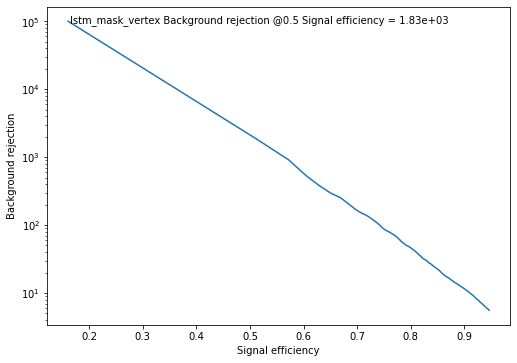

Wall time: 15.5 s


In [3]:
%%time
# Evaluate NN
model_name = 'lstm_mask_vertex'
max_ev = int(1e6)
n_constits = 10
feats = ["vert_disp", "vert_mult", "vert_PT"]
sort = 'vert_disp'
trunc = True

#B_test_path = data_path + "event_level_vert/bb2_vert.txt"
#S_test_path = data_path + "event_level_vert/dark2_vert.txt"
B_test_path = ["Data/from_cluster/bb{}.txt".format(i) for i in range(5,7)]
S_test_path = ["Data/from_cluster/dark{}.txt".format(i) for i in range(5,7)]

B_test = events_to_df_vert1(B_test_path, label=0, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc)
S_test= events_to_df_vert1(S_test_path, label=1, max_ev=max_ev, n_constits=n_constits, sort=sort, trunc=trunc) 
B_test = B_test[:len(S_test)]
S_test = S_test[:len(B_test)]

X_test_B = np.concatenate(np.array(B_test.copy()[feats]).flatten()).reshape((len(B_test), n_constits, len(feats)))
X_test_S = np.concatenate(np.array(S_test.copy()[feats]).flatten()).reshape((len(S_test), n_constits, len(feats)))

print("Number of background test jets = ", len(B_test))
print("Number of signal test jets = ", len(S_test))

test_model(model_name, X_test_B, X_test_S, analysis_dir=analysis_path)